In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts

class RLM:
    def __init__(self, data):
        # input: dataframe = x1, x2, ... , xm, y
        
        self.Y = data[data.columns[-1]].values # Y values
        self.X = data[data.columns[:-1]]
        self.X.insert(0, 'N', 1)
        self.X = self.X.to_numpy()  # design matrix
        self.datosb = data.copy()
        self.datosf = data.copy()
        
        self.n, self.p = self.X.shape
        self.m = self.p - 1
        
    def betas(self):
        return np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Y
    
    def ajustados(self):
        return self.X @ RLM.betas(self)
    
    
    def SSres(self):
        return np.sum((self.Y - RLM.ajustados(self))**2)
    
    def MSres(self):
        return RLM.SSres(self) / (self.n - (self.m + 1))
    
    def varcovbetas(self):
        return RLM.MSres(self) * np.linalg.inv(self.X.T @ self.X)
    
    def varbetas(self):
        return np.diag(RLM.varcovbetas(self))
    
    def SEbetas(self):
        return np.sqrt(RLM.varbetas(self))
    
    def hatmatrix(self):
        return self.X @ np.linalg.inv(self.X.T @ self.X) @ self.X.T
    
    def SSr(self):
        return np.sum((RLM.ajustados(self) - np.mean(self.Y))**2)
    
    def SSt(self):
        return np.sum((self.Y - np.mean(self.Y))**2)
    
    def MSr(self):
        return RLM.SSr(self) / self.m
    
    def f0(self):
        return RLM.MSr(self) / RLM.MSres(self)
    
    def significancia(self):
        return sts.f.cdf(RLM.f0(self), self.m, self.n - (self.m + 1))

    def estadisticos_t(self):
        estadisticos_t_individuales = list(abs(RLM.betas(self) / RLM.SEbetas(self)))
        estadisticos_t_individuales.pop(0)
        return estadisticos_t_individuales
    
    def significancias_t(self):
        return list(sts.t.cdf(np.array(RLM.estadisticos_t(self)), self.n - (self.m + 1)) - sts.t.cdf(-np.array(RLM.estadisticos_t(self)), self.n - (self.m + 1)))
        
    def backwards(self):
        for j in range(self.m - 1):
            
            signifs = []
            for i in range(0, len(self.datosb.iloc[0]) - 1):
                datos_i = self.datosb.copy()
                datos_i.drop(datos_i.columns[i], axis=1, inplace=True)
                signifs.append(RLM(datos_i).significancia()) # criterioooo
                
            x_menos_signif = signifs.index(max(signifs)) + 1

            if RLM(self.datosb).significancia() > max(signifs):  # criteriooo
                print(f'Modelo:{self.datosb.columns.values[:]}, significancia:{RLM(self.datosb).significancia()}')
                break
            else:
                self.datosb.drop(self.datosb.columns[x_menos_signif - 1], axis=1, inplace=True)
                print(f'Modelo:{self.datosb.columns.values[:]}, significancia:{RLM(self.datosb).significancia()}')
                
                
#     def forward(self):
#         signifs = []
#         for i in range(self.m):
#             datos_i = self.datosf.copy()
#             datos_i.drop(datos_i.columns[0:i], axis=1, inplace=True) # se modifican los datos para probar a cada uno
#             datos_i.drop(datos_i.columns[1:-1], axis=1, inplace=True)
#             signifs.append(RLM(datos_i).significancia())
            
#         x_mas_signif = signifs.index(max(signifs)) + 1
#         datos_i = self.datosf.copy()
#         datos_i.drop(datos_i.columns[0:x_mas_signif-1], axis=1, inplace=True) # se guarda el modelo con signif mas alta
#         datos_i.drop(datos_i.columns[1:-1], axis=1, inplace=True)
#         self.datosf.drop(self.datosf.columns[x_mas_signif-1], axis=1, inplace=True) # actualizamos los datos completos quitando al mas signif
    
#         for j in range(self.m - 1):
            
#         for j in range(self.m - 1):


    def residuales(self):
        return self.Y - RLM.ajustados(self)
    
    
    def residuales_est(self):
        return RLM.residuales(self)/np.sqrt(RLM.MSres(self))
    
    def graficar_res_est(self):
        ez = RLM.residuales_est(self)
        valores = np.arange(1,len(ez)+1)
        plt.plot(valores,ez,"o")
        plt.title('GRAFICA RESIDUALES ESTANDARIZADOS')
        plt.grid()
        plt.show()

    
    def prueba_individual(self, valor_propuesto, i, alpha): 
        estadisticos = abs((RLM.betas(self) - valor_propuesto) / RLM.SEbetas(self))
        estadistico_betai = estadisticos[i]
        t = sts.t.ppf(1-alpha/2, self.n-(self.m+1)) 
        if abs(estadistico_betai) < t:
            resultado = 'Se acepta H0'
        else:
            resultado = 'Se rechaza H0'
        return estadistico_betai, t, resultado
    
    def r2adj(self):
        return 1 - ( RLM.MSres(self) / ((RLM.SSt(self) / (self.n - 1))))
    
    def splines(self, tipo, knots):
        f, c = self.X.shape
        if c > 2:
            return('El modelo contiene más de un regresor')
        muestra = self.X.copy()
        muestra = pd.DataFrame(muestra)
        muestra.drop(muestra.columns[0], axis=1, inplace=True)
        xvalues = muestra[1].values
        # generar valores para graficar 
        valores = []
        knots.sort()
        for i in range(len(knots)+1):
            if i == 0:
                valores.append(np.linspace(min(xvalues), knots[i], 100))
            elif i == len(knots):
                valores.append(np.linspace(knots[i-1], max(xvalues), 100))
            else:
                valores.append(np.linspace(knots[i-1], knots[i], 100))
        
        # generar los modelos y los datos correspondientes
        n_modelos = len(knots) + 1
        if tipo == 'cuadradosc':
            for i in range(len(knots)):
                nom1 = str(i) + 'r1'
                nom2 = str(i) + 'r2'
                muestra['x2'] = xvalues**2
                muestra[nom1] = (xvalues - knots[i])
                muestra[nom2] = (xvalues - knots[i])**2
                muestra.loc[muestra[1] < knots[i], [nom1]] = 0
                muestra.loc[muestra[1] < knots[i], [nom2]] = 0
            muestra['Y'] = self.Y  # ojoo no nombrar con otro nombre
            muestranp = muestra.to_numpy()
            
            
            
            betas = RLM(muestra).betas()

            def mod0(x):
                return betas[0] + betas[1]*x + betas[2]*x**2
            
            
            modelos = [mod0]
            for i in range(1):
                def modi(x):
                    return betas[i + 3]*(x-knots[i]) + betas[i + 4]*(x-knots[i])**2
                modelos.append(modi)
                def modi1(x):
                    return betas[i + 5]*(x-knots[1]) + betas[i + 6]*(x-knots[1])**2
                modelos.append(modi1)
                def modi2(x):
                    return betas[i + 7]*(x-knots[2]) + betas[i + 8]*(x-knots[2])**2
                modelos.append(modi2)
                def modi3(x):
                    return betas[i + 9]*(x-knots[3]) + betas[i + 10]*(x-knots[3])**2
                modelos.append(modi3)
#             return modelos
            # crear funcion que crea lista de la acumulacion de las funciones
            def sumasmod(funciones):
                funciones_acumuladas = []
                acumulador = None
                for funcion in funciones:
                    if acumulador is None:
                        acumulador = funcion
                    else:
                        def acumulada(x, acumulador=acumulador, funcion=funcion):
                            return acumulador(x) + funcion(x)
                        acumulador = acumulada
                    funciones_acumuladas.append(acumulador)
                return funciones_acumuladas
            
            grafica = RLM(muestra).graficar_res_est()
            return sumasmod(modelos), valores, xvalues, self.Y, n_modelos, muestra

############################################################################################
            mod_final = []
            for i in range(n_modelos):
                mod_final.append(modelos_listos[i])
            
            return modelos_listos
#             def a(x):
#                 return betas[0] + betas[1]*x + betas[2]*x**2
#             def b(x):
#                 return a(x) + betas[3]*(x-knots[0]) + betas[4]*(x-knots[0])**2
#             modelos_listos = [a, b]

            


            for i in range(n_modelos):
#                 plt.figure(figsize=(10, 5))
#                 plt.scatter(xvalues, self.Y) 
                plt.plot(valores[i], modelos_listos[i](valores[i]))
    
            plt.scatter(xvalues, self.Y)
            plt.xlabel('X-axis')
            plt.ylabel('Y-axis')
            plt.legend()
            plt.title('SPLINES CUADRATICOS CONTINUOS')
            plt.grid(True)

            # Show the plot
            plt.show()
            
##### ##### #######3 ######3                ###########################################3
        elif tipo == 'cuadradoss':
            for i in range(len(knots)):
                nom2 = str(i) + 'r2'
                muestra['x2'] = xvalues**2
                muestra[nom2] = (xvalues - knots[i])**2
                muestra.loc[muestra[1] < knots[i], [nom2]] = 0
            muestra['Y'] = self.Y  # ojoo no nombrar con otro nombre
            muestranp = muestra.to_numpy()  
            betas = RLM(muestra).betas()
            
            def mod0(x):
                return betas[0] + betas[1]*x + betas[2]*x**2
                        
            modelos = [mod0]
            for i in range(1):
                def modi(x):
                    return betas[i + 3]*(x-knots[i])**2
                modelos.append(modi)
                def modi1(x):
                    return betas[i + 4]*(x-knots[1])**2
                modelos.append(modi1)
                def modi2(x):
                    return betas[i + 5]*(x-knots[2])**2
                modelos.append(modi2)
                def modi3(x):
                    return betas[i + 6]*(x-knots[3])**2
                modelos.append(modi3)

#             return modelos
            # crear funcion que crea lista de la acumulacion de las funciones
            def sumasmod(funciones):
                funciones_acumuladas = []
                acumulador = None
                for funcion in funciones:
                    if acumulador is None:
                        acumulador = funcion
                    else:
                        def acumulada(x, acumulador=acumulador, funcion=funcion):
                            return acumulador(x) + funcion(x)
                        acumulador = acumulada
                    funciones_acumuladas.append(acumulador)
                return funciones_acumuladas
            grafica = RLM(muestra).graficar_res_est()
            return sumasmod(modelos), valores, xvalues, self.Y, n_modelos, muestra
        
        elif tipo == 'cubicosc':
            for i in range(len(knots)):
                nom1 = str(i) + 'r1'
                nom2 = str(i) + 'r2'
                nom3 = str(i) + 'r3'
                
                muestra['x2'] = xvalues**2
                muestra['x3'] = xvalues**3
                muestra[nom1] = (xvalues - knots[i])
                muestra[nom2] = (xvalues - knots[i])**2
                muestra[nom3] = (xvalues - knots[i])**3
                muestra.loc[muestra[1] < knots[i], [nom1]] = 0
                muestra.loc[muestra[1] < knots[i], [nom2]] = 0
                muestra.loc[muestra[1] < knots[i], [nom3]] = 0
            muestra['Y'] = self.Y  # ojoo no nombrar con otro nombre
            muestranp = muestra.to_numpy()
            
            
            betas = RLM(muestra).betas()
            
            def mod0(x):
                return betas[0] + betas[1]*x + betas[2]*x**2 + betas[3]*x**3
            
            
            modelos = [mod0]
            for i in range(1):
                def modi(x):
                    return betas[i + 4]*(x-knots[i]) + betas[i + 5]*(x-knots[i])**2 + betas[i + 6]*(x-knots[i])**3
                modelos.append(modi)
                def modi1(x):
                    return betas[i + 7]*(x-knots[1]) + betas[i + 8]*(x-knots[1])**2 + betas[i + 9]*(x-knots[1])**3

                modelos.append(modi1)
                def modi2(x):
                    return betas[i + 10]*(x-knots[2]) + betas[i + 11]*(x-knots[2])**2 + betas[i + 12]*(x-knots[2])**3

                modelos.append(modi2)
                def modi3(x):
                    return betas[i + 13]*(x-knots[3]) + betas[i + 14]*(x-knots[3])**2 + betas[i + 15]*(x-knots[3])**3

                modelos.append(modi3)
#             return modelos
            # crear funcion que crea lista de la acumulacion de las funciones
            def sumasmod(funciones):
                funciones_acumuladas = []
                acumulador = None
                for funcion in funciones:
                    if acumulador is None:
                        acumulador = funcion
                    else:
                        def acumulada(x, acumulador=acumulador, funcion=funcion):
                            return acumulador(x) + funcion(x)
                        acumulador = acumulada
                    funciones_acumuladas.append(acumulador)
                return funciones_acumuladas

            grafica = RLM(muestra).graficar_res_est()
            return sumasmod(modelos), valores, xvalues, self.Y, n_modelos, muestra
        
        elif tipo == 'cubicoss':
            for i in range(len(knots)):
                nom3 = str(i) + 'r3'
                muestra['x2'] = xvalues**2
                muestra['x3'] = xvalues**3
                muestra[nom3] = (xvalues - knots[i])**3

                muestra.loc[muestra[1] < knots[i], [nom3]] = 0
            muestra['Y'] = self.Y  # ojoo no nombrar con otro nombre
            muestranp = muestra.to_numpy()
            
            betas = RLM(muestra).betas()
            
            def mod0(x):
                return betas[0] + betas[1]*x + betas[2]*x**2 + betas[3]*x**3
            
            
            modelos = [mod0]
            for i in range(1):
                def modi(x):
                    return betas[i + 4]*(x-knots[i])**3
                modelos.append(modi)
                def modi1(x):
                    return betas[i + 5]*(x-knots[1])**3
                modelos.append(modi1)
                def modi2(x):
                    return betas[i + 6]*(x-knots[2])**3
                modelos.append(modi2)
                def modi3(x):
                    return betas[i + 7]*(x-knots[3])**3
                modelos.append(modi3)

#             return modelos
            # crear funcion que crea lista de la acumulacion de las funciones
            def sumasmod(funciones):
                funciones_acumuladas = []
                acumulador = None
                for funcion in funciones:
                    if acumulador is None:
                        acumulador = funcion
                    else:
                        def acumulada(x, acumulador=acumulador, funcion=funcion):
                            return acumulador(x) + funcion(x)
                        acumulador = acumulada
                    funciones_acumuladas.append(acumulador)
                return funciones_acumuladas
            grafica = RLM(muestra).graficar_res_est()
            return sumasmod(modelos), valores, xvalues, self.Y, n_modelos, muestra

### Ejemplo de uso

In [10]:
datos = pd.read_csv("muestraparcial.csv")
datos.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,2,4,0,0,5,4,1,0,-3
1,1,1,1,2,0,1,5,1,10
2,3,3,3,2,5,4,0,5,11
3,0,5,4,2,5,1,3,3,15
4,3,0,2,0,3,0,1,0,-1


In [11]:
modelo = RLM(datos)

In [12]:
modelo.r2adj()

0.5875816501808258

In [13]:
modelo.betas()

array([-9.38465201, -0.18246703,  1.13113272,  1.23020004,  1.29903787,
        0.45139717, -0.42881903,  1.56146556,  1.70634837])

In [14]:
modelo.backwards()

Modelo:['X2' 'X3' 'X4' 'X5' 'X6' 'X7' 'X8' 'Y'], significancia:0.9999999411867245
Modelo:['X2' 'X3' 'X4' 'X6' 'X7' 'X8' 'Y'], significancia:0.9999999778929842
Modelo:['X2' 'X3' 'X4' 'X7' 'X8' 'Y'], significancia:0.9999999915612922
Modelo:['X2' 'X3' 'X4' 'X7' 'X8' 'Y'], significancia:0.9999999915612922


In [15]:
modelo.SSr() + modelo.SSres() 

2613.3800000000006

In [16]:
modelo.SSt()

2613.3800000000006

### SPLINES 

In [51]:
datos = pd.read_csv('Muestra3.csv')
datos.head()

,X,Y
0,0.0544,1.9293
1,0.0546,2.3953
2,0.3797,4.0164
3,0.5865,3.0239
4,0.6862,2.3868


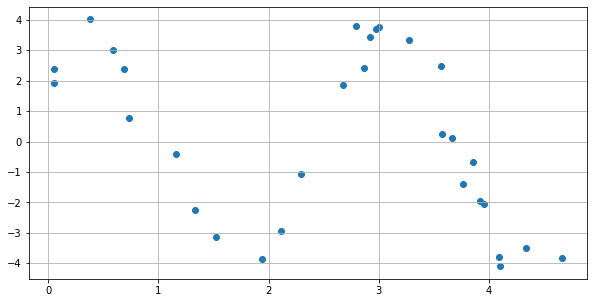

In [31]:
x = datos['X']
y = datos['Y']
plt.figure(figsize=(10, 5))
plt.grid()
plt.scatter(x, y)

In [35]:
modelo = RLM(datos)

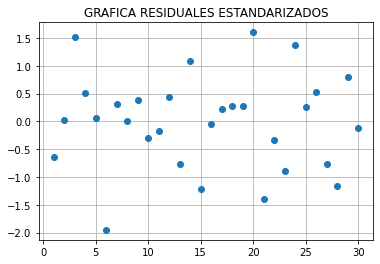

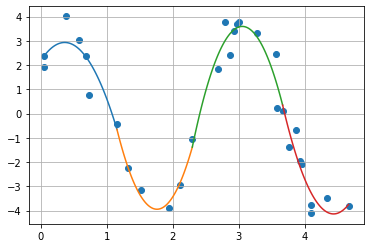

In [47]:
mod, val, x, y, n , muestra = modelo.splines('cuadradosc', [1.1561, 2.2971, 3.6645])
for i in range(n):
    plt.plot(val[i], mod[i](val[i]))
plt.scatter(x, y)
plt.grid()

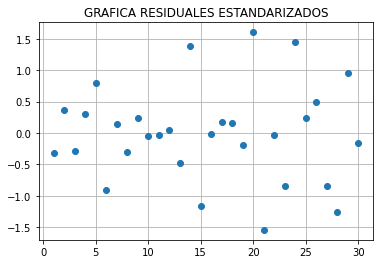

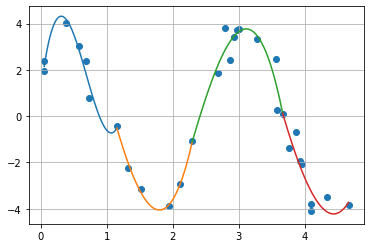

In [50]:
mod, val, x, y, n , muestra = modelo.splines('cubicosc', [1.1561, 2.2971, 3.6645])
for i in range(n):
    plt.plot(val[i], mod[i](val[i]))
plt.scatter(x, y)
plt.grid()

### Modelo simple

In [178]:
class RLS:
    def __init__(self, x, y):
        self.x = np.array(x)
        self.y = np.array(y)
        
    def xbarra(self):
        return np.mean(x)
    
    def ybarra(self):
        return np.mean(y)
    
    def Sxx(self):
        return np.sum((self.x - RLS.xbarra(self))**2)
    
    def Sxy(self):
        return np.sum((self.x - RLS.xbarra(self))*(self.y - RLS.ybarra(self)))
    
    def betas(self):
        return [RLS.ybarra(self) - RLS.xbarra(self)*(RLS.Sxy(self) / RLS.Sxx(self)), RLS.Sxy(self) / RLS.Sxx(self)]
    
    def ajustados(self):
        return np.array(RLS.betas(self)[0] + RLS.betas(self)[1]*self.x)
    
    def modelo(self, a):
        return RLS.betas(self)[0] + RLS.betas(self)[1]*a
    
    def grafica(self):
        plt.scatter(self.x, self.y)
        plt.plot(self.x, RLS.modelo(self, self.x), color='red')
        plt.grid()
        
    def prueba_2colas(self, valor_propuesto, i, alpha):
        estadístico = abs(RLS.betas(self)[i] - valor_propuesto)


In [175]:
datos = pd.read_csv('practicapaco.csv')
x = datos['X']
y = datos['Y']


In [126]:
datos.head()

,X,Y
0,11.21,16.56
1,14.58,21.20
2,4.10,7.54
3,19.27,24.98
4,7.38,9.75


In [129]:
rlsa = RLS(x, y)

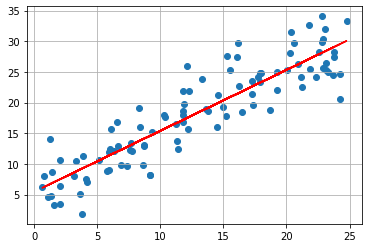

In [136]:
rlsa.grafica()